## 1. Imports

In [165]:
import torch
from torch import nn
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from timeit import default_timer as timer
from tqdm.notebook import tqdm
from torchinfo import summary
from pathlib import Path
import torch.nn.utils.prune as prune
import torch.nn.functional as F
from ptflops import get_model_complexity_info
import psutil

## 2. Data preparation

Load dataset

In [166]:
dataset = pd.read_csv('smoking_driking_dataset_Ver01.csv')

Remove "used to smoke" patients

In [167]:
# Remove non smokers that used to smoke before from dataset
dataset = dataset[dataset['SMK_stat_type_cd'] != 2]

Make `male = 0` and `female = 1`

In [168]:
dataset['sex'] = dataset['sex'].replace('Male', 0.0)
dataset['sex'] = dataset['sex'].replace('Female', 1.0)

Set `still smoking` to `1` and `never smoked` to `2`

In [169]:
dataset['SMK_stat_type_cd'] = dataset['SMK_stat_type_cd'].apply(lambda x: 1.0 if x == 3.0 else 0.0) # Smokers: 1 non smokers: 0

Remove some features

In [170]:
# Remove some input features from dataset
dataset = dataset.drop(['waistline','sight_left','sight_right','hear_left','hear_right','urine_protein','DRK_YN'], axis=1)

Cound smokers and non smokers

In [171]:
print(f'Number of smokers in the dataset: {len(dataset[dataset["SMK_stat_type_cd"]==1])}')
print(f'Number of non-smokers in the dataset: {len(dataset[dataset["SMK_stat_type_cd"]==0])}')

Number of smokers in the dataset: 213954
Number of non-smokers in the dataset: 602441


Drop 60% of smokers

In [172]:
dataset = dataset.drop(dataset.query('SMK_stat_type_cd == 0').sample(frac=.66).index)

In [173]:
print(f'Number of smokers in the dataset: {len(dataset[dataset["SMK_stat_type_cd"]==1])}')
print(f'Number of non-smokers in the dataset: {len(dataset[dataset["SMK_stat_type_cd"]==0])}')

Number of smokers in the dataset: 213954
Number of non-smokers in the dataset: 204830


### Test drop features from dataset

In [174]:
# dataset = dataset.drop(['sex'], axis=1)
# dataset = dataset.drop(['age'], axis=1)
# dataset = dataset.drop(['height'], axis=1)
# dataset = dataset.drop(['weight'], axis=1)

### Construct X and Y

In [175]:
# Construct pandas dataframes for X and y values
df_X = dataset.drop(['SMK_stat_type_cd'], axis=1)
df_y = pd.DataFrame(dataset['SMK_stat_type_cd'])

### Built correlation map

In progress

In [176]:
# def corr_scatter(df: pd.DataFrame, target: str):
#     # get column names from df
#     # iterate through all columns and plot scatterplot for all columns
#     result = df.head(50)
#     column_names = list(result.columns)
#     column_names.remove(target)

#     x = result['weight'].values
#     print(len(x))
#     y = df[target].head(50).values
#     print(len(y))
    
#     plt.figure(figsize=(14, 8))
#     plt.scatter(x, y, marker='+', s=50)  
   

In [177]:

# corr_scatter(dataset, 'height')

In [178]:
corr = dataset.corr()

<Axes: >

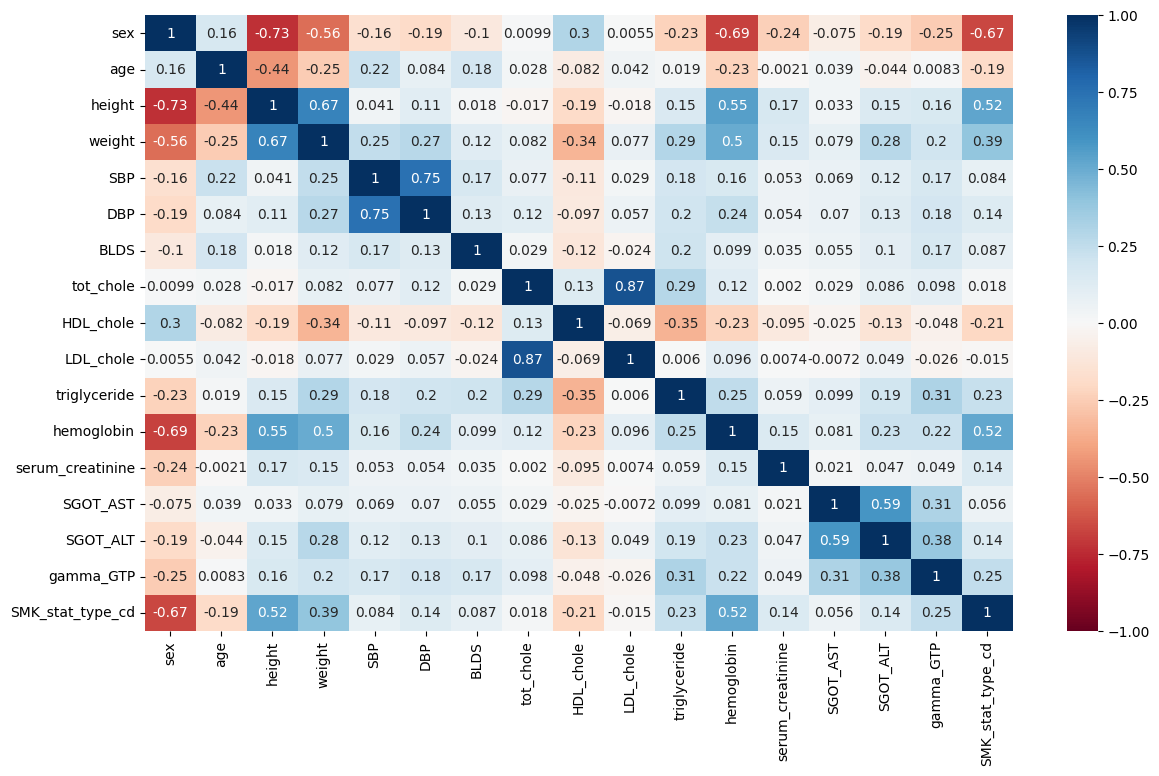

In [179]:
# Show variable correlation relations with respect to 'SMK_stat_type_cd'
plt.figure(figsize=(14, 8))
sns.heatmap(corr, cmap='RdBu', vmin=-1, vmax=1, annot=True, annot_kws={'fontsize':10})
# More heatmap arguments
# square=True will make the squares well.. squares

### Convert dataframes to tensors (dataframe -> numpy array -> torch tensor)

In [180]:
# Train Test Split, Set X, y
X_train, X_test, y_train, y_test = train_test_split(df_X.to_numpy(), df_y.to_numpy(), test_size=0.2, random_state=1)

# Convert X features to float tensors
X_train = torch.FloatTensor(X_train)
X_test = torch.FloatTensor(X_test)

# Conver y labels to float tensors
y_train = torch.FloatTensor(y_train)
y_test = torch.FloatTensor(y_test)

#Normalize inputs
# X_train = torch.nn.functional.normalize(X_train)
# X_test = torch.nn.functional.normalize(X_test)

In [181]:
print(f'Training vs testing size: {X_train.shape} / {X_test.shape}')

Training vs testing size: torch.Size([335027, 16]) / torch.Size([83757, 16])


In [182]:
# Calculate accuracy
def accuracy_fn(y_pred, y_true):
    # print(f'prediction {y_pred} true: {y_true} ')
    correct = torch.eq(y_true, y_pred).sum().item()
    return (correct / len(y_pred)) * 100

In [183]:
def print_train_time(start: float, end: float, device: torch.device = None):
    """Prints difference between start and end time.
    """
    total_time = end - start
    print(f'Train time on {device}: {total_time:.3f} seconds')
    # return total_time

In [184]:
# nn.functional.normalize(X_train[:10], dim=0)

## 3. Model definition and training

In [185]:
# class SmokersBinaryClassification(torch.nn.Module):
#     def __init__(self, input_features, output_features, hidden_layers, hidden_features):
#         super(SmokersBinaryClassification, self).__init__()  
#         self.linear_layer_stack = nn.Sequential(
#             nn.Linear(in_features=input_features, out_features=hidden_features),
#             nn.ReLU()
#         )
#         for i in range(hidden_layers):
#             self.linear_layer_stack.add_module(f'{i*2+2}', nn.Linear(in_features=hidden_features, out_features=hidden_features))
#             self.linear_layer_stack.add_module(f'{i*2+3}', nn.ReLU())
        
#         self.linear_layer_stack.add_module(f'{hidden_layers*2+2}', nn.Linear(in_features=hidden_features, out_features=output_features))
    
#     def forward(self, x):
#         return self.linear_layer_stack(x)

In [186]:
class SmokersBinaryClassification2(torch.nn.Module):
    def __init__(self, input_features, output_features=1):
        super(SmokersBinaryClassification2, self).__init__()  
        self.stack = nn.Sequential(
            nn.Linear(in_features=input_features, out_features=64),
            nn.ReLU(),
            nn.Linear(in_features=64, out_features=64),
            nn.ReLU(),
            nn.Linear(in_features=64, out_features=output_features),
            # nn.Sigmoid()
        )
        # self.linear = nn.Linear(in_features=input_features, out_features=output_features)
       
    def forward(self, x):        
        # return torch.sigmoid(self.linear(x))
        return self.stack(x)

In [187]:
# Setup device
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [188]:
IN_FEATURES = X_train.shape[1]

In [189]:
# model = SmokersBinaryClassification(input_features=IN_FEATURES, output_features=1, hidden_layers=2, hidden_features=8).to(device) # 10000 epochs 82.74
# model = SmokersBinaryClassification(input_features=16, output_features=1, hidden_features=32) # 5000 epochs 79.10
# model = SmokersBinaryClassification(input_features=IN_FEATURES, output_features=1, hidden_layers=2, hidden_features=16).to(device) # 5000 epochs 78.98
# model = SmokersBinaryClassification(input_features=16, output_features=1, hidden_layers=2, hidden_features=4) # 5000 epochs 78.98
# model = SmokersBinaryClassification(input_features=15, output_features=1, hidden_layers=1, hidden_features=15) # 5000, 79.24
# model = SmokersBinaryClassification(input_features=16, output_features=1, hidden_layers=3, hidden_features=16)
# model = SmokersBinaryClassification(input_features=IN_FEATURES, output_features=1, hidden_layers=4, hidden_features=128).to(device)

model = SmokersBinaryClassification2(input_features=IN_FEATURES).to(device)
print(f'Model sumary {summary(model)}\n')

macs, params = get_model_complexity_info(model, (80000, 16), as_strings=True,
                                           print_per_layer_stat=True, verbose=False)
print('{:<30}  {:<8}'.format('Computational complexity: ', macs))
print('{:<30}  {:<8}'.format('Number of parameters: ', params))

Model sumary =================================================================
Layer (type:depth-idx)                   Param #
SmokersBinaryClassification2             --
├─Sequential: 1-1                        --
│    └─Linear: 2-1                       1,088
│    └─ReLU: 2-2                         --
│    └─Linear: 2-3                       4,160
│    └─ReLU: 2-4                         --
│    └─Linear: 2-5                       65
Total params: 5,313
Trainable params: 5,313
Non-trainable params: 0

SmokersBinaryClassification2(
  5.31 k, 100.000% Params, 424.96 MMac, 97.647% MACs, 
  (stack): Sequential(
    5.31 k, 100.000% Params, 424.96 MMac, 97.647% MACs, 
    (0): Linear(1.09 k, 20.478% Params, 81.92 MMac, 18.824% MACs, in_features=16, out_features=64, bias=True)
    (1): ReLU(0, 0.000% Params, 5.12 MMac, 1.176% MACs, )
    (2): Linear(4.16 k, 78.299% Params, 327.68 MMac, 75.294% MACs, in_features=64, out_features=64, bias=True)
    (3): ReLU(0, 0.000% Params, 5.12 MMac, 1.

### Loss and optimizer functions

In [190]:
# loss_fn = torch.nn.BCELoss().to(device)
loss_fn = torch.nn.BCEWithLogitsLoss().to(device)
# optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
optimizer= torch.optim.Adam(model.parameters(), lr=0.01)

### Training loop

In [191]:
# torch.manual_seed(42)

epochs = 10000

X_train, y_train, X_test, y_test = X_train.to(device), y_train.to(device), X_test.to(device), y_test.to(device)

start_time = timer()
start_resources = psutil.cpu_times()

for epoch in tqdm(range(epochs), desc='Training...'):
    model.train()

    # 1. Forward passs
    y_hat = model(X_train)
    loss = loss_fn(y_hat, y_train)    

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Calculate prediction accuracy
    y_train_pred = torch.round(torch.sigmoid(y_hat))        #if not using sigmoid on model output
    # y_train_pred = torch.round(y_hat)                     #prediction probabilities -> prediction labels
    acc = accuracy_fn(y_pred=y_train_pred, y_true=y_train)

    ### Testing
    model.eval()
    with torch.inference_mode():
        y_hat = model(X_test)
        test_loss = loss_fn(y_hat, y_test)

        y_test_pred = torch.round(torch.sigmoid(y_hat))
        # y_test_pred = torch.round(y_hat)
        test_acc = accuracy_fn(y_pred=y_test_pred, y_true=y_test)

    if epoch % 50 == 0 and epoch != 0             :
        print(f'Epoch: {epoch:04d} | Loss: {loss:.4f}, Acc: {acc:.2f}% | Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%')

end_time = timer()
end_resources = start_resources = psutil.cpu_times()

print(f'Resources: {start_resources}')


print_train_time(start=start_time, end=end_time, device=device)

Training...:   0%|          | 0/10000 [00:00<?, ?it/s]

Epoch: 0050 | Loss: 0.6236, Acc: 67.09% | Test Loss: 0.6213, Test Acc: 67.62%
Epoch: 0100 | Loss: 0.5093, Acc: 75.93% | Test Loss: 0.5090, Test Acc: 76.00%
Epoch: 0150 | Loss: 0.4936, Acc: 76.70% | Test Loss: 0.4958, Test Acc: 77.58%
Epoch: 0200 | Loss: 0.4558, Acc: 79.78% | Test Loss: 0.4737, Test Acc: 78.12%
Epoch: 0250 | Loss: 0.4302, Acc: 81.68% | Test Loss: 0.4343, Test Acc: 81.19%
Epoch: 0300 | Loss: 0.4393, Acc: 81.11% | Test Loss: 0.4660, Test Acc: 79.38%
Epoch: 0350 | Loss: 0.4127, Acc: 82.91% | Test Loss: 0.4148, Test Acc: 82.83%
Epoch: 0400 | Loss: 0.4093, Acc: 83.02% | Test Loss: 0.4106, Test Acc: 83.07%
Epoch: 0450 | Loss: 0.4143, Acc: 82.90% | Test Loss: 0.4109, Test Acc: 82.96%
Epoch: 0500 | Loss: 0.4060, Acc: 83.15% | Test Loss: 0.4075, Test Acc: 83.15%
Epoch: 0550 | Loss: 0.4095, Acc: 83.06% | Test Loss: 0.4094, Test Acc: 82.99%
Epoch: 0600 | Loss: 0.5700, Acc: 75.31% | Test Loss: 0.5642, Test Acc: 78.84%
Epoch: 0650 | Loss: 0.4144, Acc: 82.97% | Test Loss: 0.4148, Tes

Testing split data

In [194]:
with torch.inference_mode():
    X_test, y_test = X_test.to(device), y_test.to(device)
    y_hat = model(X_test)
    y_test_pred = torch.round(torch.sigmoid(y_hat))
print(f'Test accuracy: {accuracy_fn(y_pred=y_test_pred, y_true=y_test):.2f}%')

Test accuracy: 83.47%


Save model

## Save/load model and test in inference mode

In [195]:
MODEL_PATH = Path('saved_models')
MODEL_PATH.mkdir(parents=True, exist_ok=True)
MODEL_NAME = 'in-64-64-out-83p35-10000epoch.pth'
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

def save_model():  
    torch.save(obj=model.state_dict(), f=MODEL_SAVE_PATH)

# save_model()

Load model

In [52]:
# loaded_model = SmokersBinaryClassification2(input_features=16).to(device)
# loaded_model.load_state_dict(torch.load(f=MODEL_SAVE_PATH))


<All keys matched successfully>

Or use trained model

In [196]:
loaded_model = model

Data set header meanings

- `SBP`:	Systolic blood pressure[mmHg]
- `DBP`:	Diastolic blood pressure[mmHg]
- `BLDS`:	BLDS or FSG(fasting blood glucose)[mg/dL]
- `SGOT_AST`:	SGOT(Glutamate-oxaloacetate transaminase) AST(Aspartate transaminase)[IU/L]
- `SGOT_ALT`:	ALT(Alanine transaminase)[IU/L]
- `gamma_GTP`:	y-glutamyl transpeptidase[IU/L]
- `SMK_stat_type_cd`: 0: NO, 1:YES. Original: (Smoking state, 1(never), 2(used to smoke but quit), 3(still smoke))

In [206]:
data = torch.tensor([0.0, 40, 170, 79, 118, 75, 91, 174, 40, 100, 134, 15.3, 0.8, 27.1, 26.0, 38], dtype=torch.float32).to(device) # Mine
# data = torch.tensor([118, 75, 91, 174, 40, 100, 134, 15.3, 0.8, 27.1, 26.0, 38], dtype=torch.float32).to(device) # Mine reduced


In [204]:
data = torch.tensor([0.0, 60, 175, 90, 140, 90, 102, 179, 40, 137, 103, 17.8, 0.73, 18, 33, 73], dtype=torch.float32).to(device) # Father 2021
# data = torch.tensor([140, 90, 102, 179, 40, 137, 103, 17.8, 0.73, 18, 33, 73], dtype=torch.float32).to(device) # Father 2021 reduced

In [207]:
# Single prediction output
with torch.inference_mode():
    y_hat = loaded_model(data).to(device)

    print(f'y_hat: {y_hat}')
   
    y_test_pred = torch.round(torch.sigmoid(y_hat))
if y_test_pred == 1: 
    print(f'Is smoker with sigmoid output {torch.sigmoid(y_hat).item():.5f}')
else:
    print(f'Is not smoker with sigmoid output {torch.sigmoid(y_hat).item():.5f}')

y_hat: tensor([1.9089], device='cuda:0')
Is smoker with sigmoid output 0.87089


In [64]:
import psutil
psutil.cpu_times()

scputimes(user=1539.24, nice=1.76, system=471.86, idle=24492.41, iowait=40.92, irq=0.0, softirq=33.23, steal=0.0, guest=0.0, guest_nice=0.0)

## Pruning tests

### Test unpruned model on training split data

In [255]:
with torch.inference_mode():
    X_test, y_test = X_test.to(device), y_test.to(device)
    y_hat = loaded_model(X_test)
    y_test_pred = torch.round(y_hat)
print(f'Test accuracy: {accuracy_fn(y_pred=y_test_pred, y_true=y_test):.2f}%')

Test accuracy: 79.43%


In [256]:
summary(loaded_model)

Layer (type:depth-idx)                   Param #
SmokersBinaryClassification2             --
├─Sequential: 1-1                        --
│    └─Linear: 2-1                       544
│    └─Sigmoid: 2-2                      --
│    └─Linear: 2-3                       33
│    └─Sigmoid: 2-4                      --
Total params: 577
Trainable params: 577
Non-trainable params: 0

In [54]:
print(list(loaded_model.named_parameters()))

[('linear_layer_stack.0.weight', Parameter containing:
tensor([[ 1.1419e+01,  2.8369e-01, -2.5334e-02,  5.8164e-02, -2.4432e-02,
          1.1117e-01, -6.4167e-02, -8.7747e-03,  1.2754e-01,  1.4439e-01,
          1.8214e-01, -7.3320e-01,  1.4353e+00,  3.7245e-01,  9.4272e-02,
         -6.3113e-02],
        [-1.1654e+01, -3.6199e-01,  7.5182e-02,  6.4534e-02, -1.7600e-02,
          1.7614e-02, -2.5517e-03, -2.8645e-02,  7.4418e-02,  5.2361e-02,
          7.9399e-02,  3.0530e-01,  1.8079e+00,  2.0525e-01,  6.3439e-02,
          6.4805e-02],
        [-1.9406e+00, -3.8878e-01, -3.3955e-01,  1.3571e-01, -8.0917e-02,
          8.8149e-02,  4.6586e-02,  1.6614e-01, -1.1347e-01,  9.4442e-02,
         -1.9861e-01, -3.1419e-01,  1.6617e-01, -2.5747e-02, -7.3220e-02,
          1.1719e-01],
        [-1.0273e+01, -3.3198e-01,  2.8294e-01, -2.9193e-01, -3.6069e-02,
         -6.7856e-03, -4.6673e-02,  5.0340e-02, -3.6361e-02,  5.1715e-02,
          9.8543e-02,  1.3281e-01, -1.6693e+00,  6.8192e-02, -

In [257]:
print(list(loaded_model.named_buffers()))

[]


In [60]:
prune.l1_unstructured(loaded_model.linear_layer_stack[0], name='weight', importance_scores=0.01)

AttributeError: 'float' object has no attribute 'shape'

In [56]:
print(list(loaded_model.named_buffers()))

[]


In [57]:
summary(loaded_model)

Layer (type:depth-idx)                   Param #
SmokersBinaryClassification              --
├─Sequential: 1-1                        --
│    └─Linear: 2-1                       136
│    └─ReLU: 2-2                         --
│    └─Linear: 2-3                       72
│    └─ReLU: 2-4                         --
│    └─Linear: 2-5                       72
│    └─ReLU: 2-6                         --
│    └─Linear: 2-7                       9
Total params: 289
Trainable params: 289
Non-trainable params: 0

In [46]:
with torch.inference_mode():
    X_test, y_test = X_test.to(device), y_test.to(device)
    y_test_logits = loaded_model(X_test)
    y_test_pred = torch.round(torch.sigmoid(y_test_logits))
print(f'Test accuracy: {accuracy_fn(y_pred=y_test_pred, y_true=y_test):.2f}%')

Test accuracy: 75.28%
